In [1]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
sys.path.insert(0, "/home/tinkerer/Poisson_Solver")

In [48]:
from ccode.gates_trijunction import triangular_gates_3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle

from ccode.potential import gate_potential, linear_problem_instance
from Hamiltonian import discrete_system_coordinates, kwant_system, tight_binding_Hamiltonian
from scipy import constants
from utility import prepare_voltages
from plotting import plot_potential
import kwant
import scipy.sparse.linalg as sla
import ccode.solvers as sl
import ccode.finite_system as tj
import tinyarray as ta
import scipy.sparse.linalg as sla
import matplotlib.animation as animation
import pickle
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)

In [3]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Electrostatic potential

In [4]:
thickness_GaAs = 6
thickness_twoDEG = 4
thickness_Al2O3 = 4
thickness_gate = 2
thickness_self_Al2O3 = 4

meff = 0.023 * constants.m_e  # in Kg
eV = 1.0
bandgap_GaAs = 1.519 * eV

permittivity_metal = 5000
permittivity_GaAs = 12.18
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_GaAs = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG

density = 1.9e11  # Electron density in 2DEG per cm2
cm = 1.0
m = 1e2 * cm
density_m2 = density * m ** 2  # Electron density in 2DEG per m2
#scaling_eV = 1 / (constants.e)  # in eV
#mu = (((constants.hbar ** 2) * np.pi * density_m2) / meff) * scaling_eV

In [5]:
angle = 0.6
area = 1500
wire_width = 7
gap = 3

In [6]:
triangle_length = np.sqrt(area*np.tan(angle))
triangle_width = np.abs((triangle_length/np.tan(angle)))
top_shift = np.tan(angle)*(wire_width/2)
tunnel_length = 3
tunnel_width = wire_width

total_length = triangle_length + 2 * tunnel_length + 2 * gap - top_shift
extra_width = 10
total_width = 2 * extra_width + triangle_width
total_width = 2*total_width

In [7]:
gates = triangular_gates_3(area, angle, wire_width, tunnel_length, gap, extra_width)

In [8]:
zmin = -0.5
zmax = 0.5
xmax = triangle_width
xmin = -xmax
ymin = 0
ymax = total_length
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]

Text(0.5, 1.0, 'Planar gates configuration')

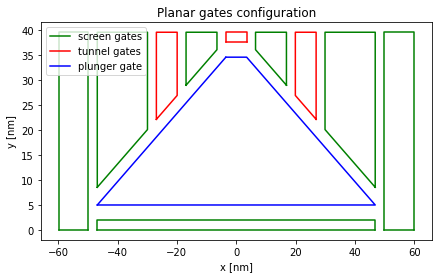

In [9]:
fig, ax = plt.subplots(figsize=(7, 4))

for _, gate in gates["screen_gates"].items():
#    gate = 10*gate
    ax.plot(gate[:, 0], gate[:, 1], "g", label='screen gates')
    ax.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "g", label='screen gates')
    
for _, gate in gates["tunel_gates"].items():
 #   gate = 10*gate
    ax.plot(gate[:, 0], gate[:, 1], "r", label='tunnel gates')
    ax.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "r", label='tunnel gates')

for _, gate in gates["plunger_gates"].items():
  #  gate = 10*gate
    ax.plot(gate[:, 0], gate[:, 1], "b", label='plunger gate')
    ax.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "b", label='plunger gate')

ax.set_ylabel('y [nm]')
ax.set_xlabel('x [nm]')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')
ax.set_title('Planar gates configuration')

In [10]:
x_c, y_c = gates['tunel_gates']['right_tunel'][3]
x_c += wire_width/2

In [11]:
layout = Layout(
    total_width, total_length, grid_width_air=grid_spacing_air, margin=(50, 50, 50), shift=(0, total_length/2, 0)
)

In [12]:
layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG
    ),
    center=True,
)

layout.add_layer(
    SimpleChargeLayer(
        "GaAs",
        thickness_GaAs,
        permittivity_GaAs,
        grid_spacing_GaAs,
    )
)

In [13]:
vertex = (
    list(gates["plunger_gates"].values()),
    list(gates["screen_gates"].values()),
    list(gates["tunel_gates"].values()),
        )

layout.add_layer(
    OverlappingGateLayer(
        vertex,
        np.hstack([list(gates[key].keys()) for key, _ in gates.items()]),
        thickness_gate,
        thickness_self_Al2O3,
        permittivity_metal,
        grid_spacing_gate,
    )
)

In [14]:
%%time
poisson_system = layout.build()
linear_problem = linear_problem_instance(poisson_system)

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 55.4 s, sys: 2.95 s, total: 58.3 s
Wall time: 58.3 s


In [15]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('mixed', 'twoDEG')], boundaries=boundaries
)

In [16]:
# %%px --local

model = "A0 * (k_x**2 + k_y**2) + V(x, y)"

A0 = (constants.hbar) ** 2 / (2 * meff * constants.e * (10e-9) ** 2)


def onsite(site, A0, V):
    (x, y,) = site.pos
    _const_0 = V(x, y)
    return (4 / (grid_spacing) ** 2) * A0 + _const_0


def hopping(site1, site2, A0):
    return -(1 / (grid_spacing) ** 2) * A0


grid_spacing = grid_spacing_twoDEG
kwant_syst = kwant_system(site_coords[:, [0, 1]], onsite, hopping, grid_spacing)
kwant_sites = np.array([site.pos for site in kwant_syst.sites])

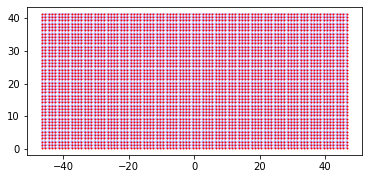

In [17]:
kwant.plot(kwant_syst, site_size=0.3, site_color='r', hop_color='b',);

In [18]:
# parameters for trijunction builder
a = 1
L = boundaries[3] - boundaries[2]
W = boundaries[1] - boundaries[0]
crds = site_coords[:, [0, 1]]
offset = crds[0]%grid_spacing

In [29]:
# voltages
depleted = -0.015

screen_voltages = {
    'right_side_screen': depleted,
    'left_side_screen': depleted,
    'right_middle_screen': depleted,
    'left_middle_screen': depleted,
    'left_screen': depleted,
    'right_screen': depleted,
    'bottom_screen': depleted
}

tunel_voltages = {
    'top_tunel': 0.02,#0.095,
    'left_tunel': -0.01,#-0.07,
    'right_tunel': 0.02#0.1
}

plunger_voltages = {'plunger_gate': 0.003}

voltages = dict()
voltages.update(screen_voltages)
voltages.update(tunel_voltages)
voltages.update(plunger_voltages)

volt = list(voltages.values())
gates = list(voltages.keys())
voltages = prepare_voltages(volt, gates)
charges = {}

electrons = 1.0  # We consider electrons

sign_potential_energy = -1.0 if electrons else 1.0

In [30]:
clean_potential = gate_potential(
    poisson_system,
    linear_problem,
    site_coords[:, [0, 1]],
    site_indices,
    voltages,
    charges,
    offset
)

In [31]:
clean_potential.update(
    (key, sign_potential_energy * value) for key, value in clean_potential.items()
)


def get_potential(x, y):
    return clean_potential[ta.array([x, y])]

In [32]:
y_c

26.964108211584808

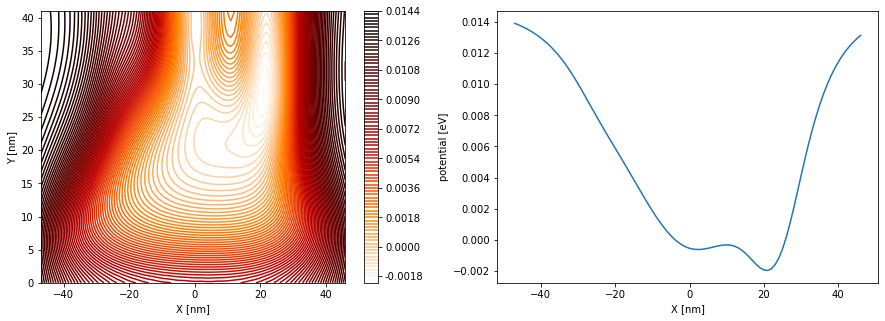

In [33]:
plot_potential([clean_potential], [27.0])

In [34]:
clean_potential = gate_potential(
    poisson_system,
    linear_problem,
    site_coords[:, [0, 1]],
    site_indices,
    voltages,
    charges,
    offset=np.array([0, 0])
)

In [35]:
def get_potential_wrap(i):
    x, y = kwant_syst.sites[i].pos
    return get_potential(x, y)

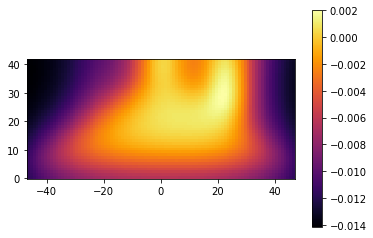

In [36]:
kwant.plotter.map(kwant_syst, get_potential_wrap, cmap='inferno');

## Save potentials

In [37]:
# Cavity voltages
a = 10e-9

In [38]:
def get_potentials(voltages, vs, key):
    potentials = {}
    for v in vs:
        voltages[key] = v
        volt = list(voltages.values())
        gates = list(voltages.keys())
        voltages_config = prepare_voltages(volt, gates)
        clean_potential = gate_potential(
            poisson_system,
            linear_problem,
            site_coords[:, [0, 1]],
            site_indices,
            voltages_config,
            charges,
            offset,
            grid_spacing=a
        )
        potentials[v] = clean_potential
    return potentials

In [39]:
key = 'plunger_gate'
volts = np.linspace(0.00, 0.01, 100)

In [40]:
%%time
potentials = get_potentials(voltages=voltages, vs=volts, key=key)

CPU times: user 20.2 s, sys: 59.5 ms, total: 20.2 s
Wall time: 20.2 s


In [41]:
voltages = list(potentials.keys())

# Trijunction

In [42]:
def inverted_triangle_junction_potential(**geometry):

    L = geometry['L']
    W = geometry['W']

    l = geometry['l']
    w = geometry['w']

    x_c = geometry['x_c']
    y_c = geometry['y_c']
    gap = geometry['gap']

    hamiltonian = """( t * (k_x**2 + k_y**2 ) - mu(x,y) )* kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta_re(x,y) * kron(sigma_0, sigma_x)
    + Delta_im(x,y) * kron(sigma_0, sigma_y)
    + B_x * kron(sigma_y, sigma_0)"""

    a = 10e-9
    template = kwant.continuum.discretize(hamiltonian, grid=a)

    def cutted_rectangle_shape(mu_qd=True, mus_nw=[True, True, True], potential=False):

        def shape(x, y):

            cut_left = -w/2 - gap/2 < (x - x_c) < w/2 + gap/2 and 0 <= (y - y_c)
            cut_right = -w/2 - gap/2 < (x + x_c) < w/2 + gap/2 and 0 <= (y - y_c)

            if 0 <= y - y_c <= l and -w/2 <= x - x_c < w/2:
                return mus_nw[0]
            elif 0 <= y - y_c <= l and -w/2 <= x + x_c < w/2:
                return mus_nw[1]
            elif 0 < (y - L) <= l and -w/2 <= x < w/2:
                return mus_nw[2]

            if 0 < y < L and -W/2 < x < W/2:
                if not cut_left and not cut_right:
                    if potential:
                        return mu_qd(x, y)
                    else:
                        return mu_qd

        return shape

    def builder_shape(**geometry):
        """Return a function used to create builder as TJ shape."""

        def system(site):
            x, y = site.pos
            f = cutted_rectangle_shape()
            return f(x, y)

        return system

    def fill_system(mu_qd, mus_nw):
        def filled(x, y):
            f = cutted_rectangle_shape(mu_qd=mu_qd, mus_nw=mus_nw)
            return f(x, y)
        return filled

    def f_params(**params):

        mus_nw = params.pop('mus_nw')
        mu_qd = params.pop('mu_qd')
        Delta = params.pop('Delta')
        phi1 = params.pop('phi1')
        phi2 = params.pop('phi2')
        f_chemical_potential = fill_system(mu_qd=mu_qd, mus_nw=mus_nw)
        f_Delta_re = fill_system(mu_qd=0, mus_nw=Delta * np.array([1, np.cos(phi1), np.cos(phi2)]))
        f_Delta_im = fill_system(mu_qd=0, mus_nw=Delta * np.array([0, np.sin(phi1), np.sin(phi2)]))

        params.update(mu=f_chemical_potential)
        params.update(Delta_re=f_Delta_re)
        params.update(Delta_im=f_Delta_im)

        return params

    def f_mu_potential(potential, mus_nw):
        shape = cutted_rectangle_shape(mu_qd=potential, mus_nw=mus_nw, potential=True)
        return shape

    def f_params_potential(potential, params):
        mus_nw = params['mus_nw']
        f = f_params(**params)
        f.update(mu=f_mu_potential(potential=potential, mus_nw=mus_nw))
        return f

    def make_junction():
        """Create finalized Builder of a rectangle filled with template"""
        junction = kwant.Builder()
        junction.fill(
            template,
            shape=builder_shape(),
            start=[0, a]
        )
        return junction

    return make_junction().finalized(), f_params, f_params_potential

In [43]:
a = 10e-9

geometry = {
    "l": 100*a,
    "w": 7*a,
    "L": L*a,
    "W": W*a,
    "gap": gap*a,
    "x_c": x_c*a,
    "y_c": y_c*a
}

In [44]:
trijunction, _, f_params_potential = inverted_triangle_junction_potential(**geometry)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


(-5e-08, 5e-07)

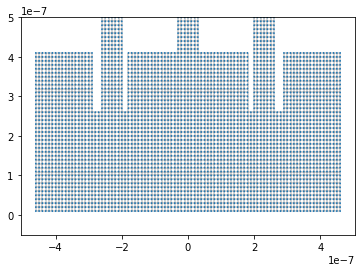

In [45]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-0.5e-7, 5e-7)

In [60]:
import ccode.potential as pt
import dask.bag as db
import ccode.tools as tl


def solver_potential(tj_system, n, potentials, params):

    def eigensystem_sla(voltage):

        system, f_params_potential = tj_system
        f_potential = tl.get_potential(potentials[voltage])

        ham_mat = system.hamiltonian_submatrix(sparse=True,
                                               params=f_params_potential(potential=f_potential, params=params))
        evals, evecs = sl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))

        return evals, evecs

    return eigensystem_sla

In [61]:
params = sl.junction_parameters(m_nw=np.ones(3), m_qd=0)
params.update(sl.finite_coupling_parameters(index=0)[1])
params

{'mus_nw': array([ 0.00239602, -2.        ,  0.00239602]),
 'mu_qd': 0,
 't': 1.6561134509633838e-18,
 'Delta': 0.0005,
 'alpha': 3e-11,
 'B_x': 0.001,
 'phi1': 0,
 'phi2': 0.06346651761967408,
 'sigma': 0,
 'a': 1e-08}

In [62]:
solver = solver_potential(tj_system=[trijunction, f_params_potential],
                          potentials=potentials,
                          params=params,
                          n=20)

In [63]:
voltages = list(potentials.keys())

In [64]:
args_db = db.from_sequence(voltages, npartitions=20)

In [65]:
result = args_db.map(solver).compute()

In [66]:
ens, wfs = tl.separate_energies_wfs(result)

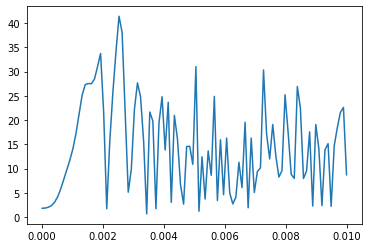

In [67]:
plt.plot(voltages, 1e6*ens.T[11])

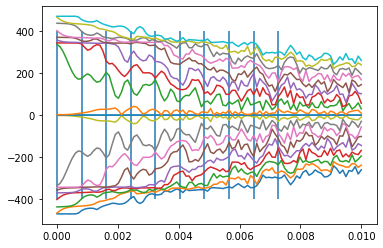

In [68]:
for level in 1e6*ens.T:
    plt.plot(voltages, level)
for i in range(10):
    plt.vlines(x=voltages[8*i], ymin=-400, ymax=400)

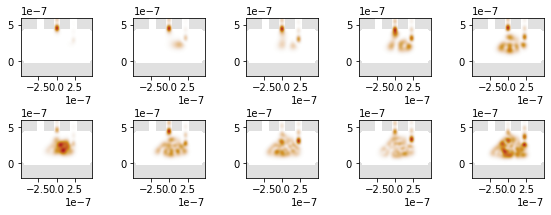

In [69]:
density = kwant.operator.Density(trijunction, np.eye(4))

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(8, 3))
fig.tight_layout(h_pad=1, w_pad=1)
i = 0
for ax in axes.flatten():
    kwant.plotter.density(trijunction, density(wfs[8*i][11]), ax=ax)
    ax.set_ylim(-2e-7, 6e-7)
    i += 1

## Results for MBS coupling

In [412]:
voltages_right_left = np.linspace(5, 9, 100)

In [87]:
left_right_en = 1e6*ens.T[11]
left_right_wfs = wfs[45][11]

In [265]:
voltages_left_top = np.linspace(2.5, 6.5, 100)

In [268]:
left_top_en = 1e6*ens.T[11]
left_top_wfs = wfs[40][11]

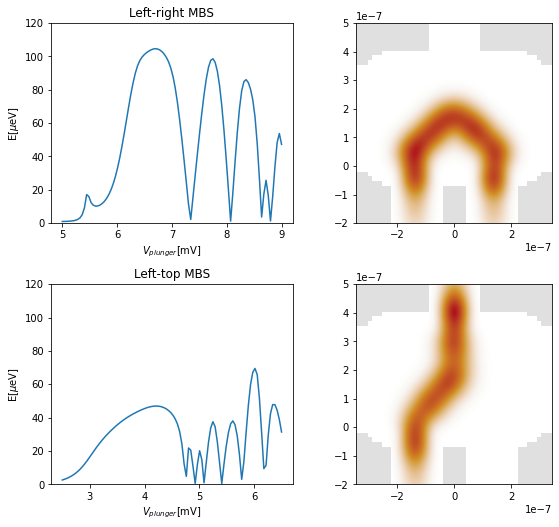

In [269]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 7))
fig.tight_layout(h_pad=4, w_pad=1)
ax[0][0].plot(voltages_right_left, left_right_en)
ax[0][0].set_ylim(0, 120)
ax[0][0].set_xlabel(r'$V_{plunger}$[mV]')
ax[0][0].set_ylabel(r'E[$\mu$eV]')
ax[0][0].set_title('Left-right MBS')
kwant.plotter.density(trijunction, density(left_right_wfs), ax=ax[0][1])
ax[0][1].set_ylim(-2e-7, 5e-7)
ax[1][0].plot(voltages_left_top, left_top_en)
ax[1][0].set_xlabel(r'$V_{plunger}$[mV]')
ax[1][0].set_ylabel(r'E[$\mu$eV]')
ax[1][0].set_ylim(0, 120)
ax[1][0].set_title('Left-top MBS')
kwant.plotter.density(trijunction, density(left_top_wfs), ax=ax[1][1])
ax[1][1].set_ylim(-2e-7, 5e-7)
plt.show()

In [186]:
ax1

<AxesSubplot:xlabel='X [nm]', ylabel='Y [nm]'>